<a href="https://colab.research.google.com/github/manavtech07/Entity_Sentiment_Analysis/blob/main/NERwithSentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [195]:
import spacy
from spacy import displacy
import pandas as pd
nlp = spacy.load('en_core_web_sm')
from collections import Counter
import requests
import flair
import ast
import spacy_transformers
import matplotlib.pyplot as plt

Loading Model

In [93]:
model = flair.models.TextClassifier.load('en-sentiment')

2023-10-26 17:54:05,988 https://nlp.informatik.hu-berlin.de/resources/models/sentiment-curated-distilbert/sentiment-en-mix-distillbert_4.pt not found in cache, downloading to /tmp/tmp2pcpu_ll


100%|██████████| 253M/253M [00:12<00:00, 21.0MB/s]

2023-10-26 17:54:19,113 copying /tmp/tmp2pcpu_ll to cache at /root/.flair/models/sentiment-en-mix-distillbert_4.pt


2023-10-26 17:54:19,799 removing temp file /tmp/tmp2pcpu_ll


#Getting Reddit Data

In [211]:
class Reddit:
    def __init__(self, client_id, secret_token, username, password):
        # first create authentication object
        auth = requests.auth.HTTPBasicAuth(client_id, secret_token)
        # build login dictionary
        login = {'grant_type': 'password',
                 'username': username,
                 'password': password}
        # setup header info (incl description of API)
        headers = {'User-Agent': 'namedentityrec/0.0.1'}
        # send request for OAuth token
        res = requests.post(f'https://www.reddit.com/api/v1/access_token',
                            auth=auth, data=login, headers=headers)
        # pull auth bearer token from response
        token = res.json()['access_token']
        # add authorization to headers dictionary
        headers['Authorization'] = f'bearer {token}'
        # add headers dict to internal attributes
        self.headers = headers
        # and api
        self.api = 'https://oauth.reddit.com'

    def get_new(self, subreddit, iters):
        # initialize dataframe to store data
        df = pd.DataFrame()
        # initialize parameters dictionary
        params = {'limit': 100}
        # iterate through several times to make sure we get all the data available
        for i in range(iters):
            # make request
            res = requests.get(f'{self.api}/r/{subreddit}/new',
                               headers=self.headers,
                               params=params)
            # check that we returned something (if not we reached end)
            if len(res.json()['data']['children']) == 0:
                print('No more found')
                return df
            # iterate through each thread recieved
            for thread in res.json()['data']['children']:
                # add info to dataframe
                df = df.append({
                    'id': thread['data']['name'],
                    'created_utc': int(thread['data']['created_utc']),
                    'subreddit': thread['data']['subreddit'],
                    'title': thread['data']['title'],
                    'selftext': thread['data']['selftext'],
                    'upvote_ratio': thread['data']['upvote_ratio'],
                    'ups': thread['data']['ups'],
                    'downs': thread['data']['downs'],
                    'score': thread['data']['score']
                }, ignore_index=True)
            # get earliest ID
            earliest = df['id'].iloc[len(df)-1]
            # add earliest ID to params
            params['after'] = earliest
        return df

In [212]:
SUB = 'investing'
CLIENT_ID = '<Your_Client_ID>'
SECRET_TOKEN = '<Your_Secret_Token>'

USER = 'Your_Username'
PWD = 'Your_Password'

reddit = Reddit(CLIENT_ID, SECRET_TOKEN, USER, PWD)

In [127]:
df = reddit.get_new(SUB, 20)

<ipython-input-122-897663ab6357>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-122-897663ab6357>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-122-897663ab6357>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-122-897663ab6357>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-122-897663ab6357>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-122-897663ab6357>:41: FutureWarning: The

No more found


In [128]:
df = df.replace({'|': ''}, regex=True)

df.to_csv('reddit_invest.csv', sep='|', index=False)

#Extracting organizations

In [129]:
def get_orgs(text):
    # process the text with our SpaCy model to get named entities
    doc = nlp(text)
    # initialize list to store identified organizations
    org_list = []
    # loop through the identified entities and append ORG entities to org_list
    for entity in doc.ents:
        if entity.label_ == 'ORG':
            org_list.append(entity.text)
    # if organization is identified more than once it will appear multiple times in list
    # we use set() to remove duplicates then convert back to list
    org_list = list(set(org_list))
    return org_list

In [130]:
df['organizations'] = df['selftext'].apply(get_orgs)

In [131]:
df.tail()

,id,created_utc,subreddit,title,selftext,upvote_ratio,ups,downs,score,organizations
845,t3_16ltso9,1695038932,investing,Is now a good time to buy gold?,The Fed and the ECB have been raising the inte...,0.46,0,0,0,"[Fed, ECB]"
846,t3_16lqasq,1695027668,investing,Daily General Discussion and Advice Thread - S...,Have a general question? Want to offer some c...,0.40,0,0,0,"[FAQ, wiki]"
847,t3_16lpmb8,1695025146,investing,Which free bond scanners(with ratings) are out...,"Presently, I find myself relying on the IBKR P...",0.33,0,0,0,[IBKR]
848,t3_16loswg,1695022024,investing,"100k salary in NYC, are there tax benefits to ...",I contribute 4% now (company matches up to 3%)...,0.82,76,0,76,[]
849,t3_16lmdel,1695013507,investing,How to optimize taxes with current income?,How can I optimize myself for taxes every year...,0.57,1,0,1,[IRA]


In [132]:
orgs = df['organizations'].to_list()
orgs = [org for sublist in orgs for org in sublist]
org_freq = Counter(orgs)
org_freq.most_common(10)

[('Fidelity', 42),
 ('FAQ', 41),
 ('wiki', 39),
 ('VOO', 38),
 ('Vanguard', 26),
 ('Fed', 17),
 ('SPY', 16),
 ('QQQ', 16),
 ('treasury', 13),
 ('Treasury', 11)]

#Sentiment Analysis

First let's get sentiments

In [140]:
def get_sentiment(text):
    # tokenize input text
    sentence = flair.data.Sentence(text)
    # make sentiment prediction
    model.predict(sentence)
    # extract sentiment direction and confidence (label and score) object
    sentiment = sentence.labels[0]
    return sentiment

In [141]:
df['sentiment'] = df['selftext'].apply(get_sentiment)

In [142]:
df.head()

,id,created_utc,subreddit,title,selftext,upvote_ratio,ups,downs,score,organizations,sentiment
0,t3_17h1xcz,1698341815,investing,Historical Data to Estimate Portfolio Value Un...,"Hi, I am trying to just roughly map out how mu...",0.50,0,0,0,[],"Sentence[173]: ""Hi, I am trying to just roughl..."
1,t3_17h0ghk,1698337844,investing,Should I invest in stocks that pay monthly div...,I was wondering if its worthwhile to have a st...,0.43,0,0,0,[],"Sentence[110]: ""I was wondering if its worthwh..."
2,t3_17h0dbx,1698337613,investing,Is Converting Traditional to Roth IRA Worth It...,I regularly accumulate small sums in my Tradit...,0.33,0,0,0,[Fidelity],"Sentence[58]: ""I regularly accumulate small su..."
3,t3_17gzcek,1698334861,investing,"Need recommendations on MM, HYSA, and Treasuries","Hello all, \n\nI've been lurking here for a fe...",0.50,0,0,0,[treasury],"Sentence[204]: ""Hello all, I've been lurking..."
4,t3_17gyeuh,1698332255,investing,TBill Maturity/Redemption Question,Hello investors! I am using money from a T bil...,0.67,1,0,1,[treasury],"Sentence[142]: ""Hello investors! I am using mo..."


In [137]:
# Define a function to handle empty lists
def safe_literal_eval(x):
    # Check if x is an empty list and return an empty list
    if x == '[]':
        return []
    # Otherwise, evaluate x using ast.literal_eval
    return ast.literal_eval(x) if isinstance(x, str) else x

# Apply the function to the 'organizations' column
df['organizations'] = df['organizations'].apply(safe_literal_eval)

In [143]:
# initialize sentiment dictionary
sentiment = {}

# loop through dataframe and extract org labels and sentiment scores into sentiment dictionary
for i, row in df.iterrows():
    # extract sentiment direction and score
    direction = row['sentiment'].value
    score = row['sentiment'].score
    # loop through each label in organizations column
    for org in row['organizations']:
        # check if org label exists in sentiment dictionary already
        if org not in sentiment.keys():
            # if it doesn't, initialize new entry in dictionary
            sentiment[org] = {'POSITIVE': [], 'NEGATIVE': []}
        # append positive/negative score to respective dictionary entry
        sentiment[org][direction].append(score)

In [145]:
sentiment['SPY']

{'POSITIVE': [],
 'NEGATIVE': [0.9994377493858337,
  0.9993102550506592,
  0.9992917776107788,
  0.9997555613517761,
  0.998356282711029,
  0.9651529788970947,
  0.9999169111251831,
  0.6957834959030151,
  0.5841540098190308,
  0.9946966171264648,
  0.9999226331710815,
  0.9991171956062317,
  0.9988705515861511,
  0.9983526468276978,
  0.999992847442627,
  0.9998776912689209]}

#Entities with Sentiment Scores

we can loop through each organization entry in the sentiment dictionary and calculate an average positive, and average negative score:

In [146]:
# initialize sentiment list
avg_sentiment = []

# loop through each organization
for org in sentiment.keys():
    # get number of positive and negative ratings
    freq = len(sentiment[org]['POSITIVE']) + len(sentiment[org]['NEGATIVE'])
    for direction in ['POSITIVE', 'NEGATIVE']:
        # assign to variable for cleaner code
        score = sentiment[org][direction]
        # if there are no entries, set to 0
        if len(score) == 0:
            sentiment[org][direction] = 0.0
        else:
            # otherwise calculate total
            sentiment[org][direction] = sum(score)
    # now calculate total amount
    total = sentiment[org]['POSITIVE'] - sentiment[org]['NEGATIVE']
    # and the average score
    avg = total/freq
    # add to sentiment list
    avg_sentiment.append({
        'entity': org,
        'positive': sentiment[org]['POSITIVE'],
        'negative': sentiment[org]['NEGATIVE'],
        'frequency': freq,
        'score': avg
    })

In [147]:
avg_sentiment[:5]

[{'entity': 'Fidelity',
  'positive': 5.278456389904022,
  'negative': 35.41107940673828,
  'frequency': 42,
  'score': -0.7174434051627204},
 {'entity': 'treasury',
  'positive': 0.7207494974136353,
  'negative': 11.823315024375916,
  'frequency': 13,
  'score': -0.8540435020740216},
 {'entity': 'GBP',
  'positive': 0.8989430069923401,
  'negative': 0.0,
  'frequency': 1,
  'score': 0.8989430069923401},
 {'entity': 'HSA',
  'positive': 0.6637986302375793,
  'negative': 4.891766548156738,
  'frequency': 6,
  'score': -0.7046613196531931},
 {'entity': 'VOO',
  'positive': 4.27515172958374,
  'negative': 31.666769802570343,
  'frequency': 38,
  'score': -0.7208320545522791}]

In [148]:
sentiment_df = pd.DataFrame(avg_sentiment)
sentiment_df.head()

,entity,positive,negative,frequency,score
0,Fidelity,5.278456,35.411079,42,-0.717443
1,treasury,0.720749,11.823315,13,-0.854044
2,GBP,0.898943,0.000000,1,0.898943
3,HSA,0.663799,4.891767,6,-0.704661
4,VOO,4.275152,31.666770,38,-0.720832


In [149]:
sentiment_df.shape

(742, 5)

We can see we have a lot of entities which have appeared once in our dataset, and because of this their score will be pushed to one extreme or the other. We can filter out anything with less than or equal to a frequency of 3 to remove many of these instances:

In [152]:
sentiment_df = sentiment_df[sentiment_df['frequency'] > 3]
print(f'size: {sentiment_df.shape}')
sentiment_df.head()

size: (39, 5)


,entity,positive,negative,frequency,score
0,Fidelity,5.278456,35.411079,42,-0.717443
1,treasury,0.720749,11.823315,13,-0.854044
3,HSA,0.663799,4.891767,6,-0.704661
4,VOO,4.275152,31.666770,38,-0.720832
5,Google,1.826536,1.998867,4,-0.043083


In [155]:
sentiment_df.sort_values('score', ascending=False).head()

,entity,positive,negative,frequency,score
226,FSKAX,1.780620,1.775931,4,0.001172
5,Google,1.826536,1.998867,4,-0.043083
135,AI,2.779995,7.922323,11,-0.467484
36,TLT,1.688995,5.730983,8,-0.505248
79,ISA,0.714045,2.998602,4,-0.571139


we can see only 1 is positive

#Visualising

In [174]:
import numpy as np

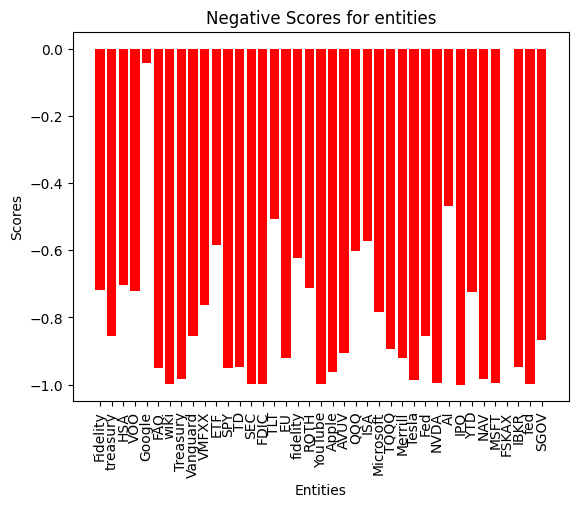

In [188]:
# Defining colors based on score
colors = ['red' if score < 0 else 'blue' for score in sentiment_df['score']]

# Create the bar plot
x = np.arange(len(sentiment_df['entity']))

plt.bar(x, sentiment_df['score'], color=colors)
plt.xlabel('Entities')
plt.ylabel('Scores')
plt.title('Negative Scores for entities')

# Rotate x-axis labels vertically
plt.xticks(x, sentiment_df['entity'], rotation='vertical')

plt.show()